### Import modules and verify they work? 

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import os
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy
import xarray as xr
from tqdm import tqdm
import glob
from devtools import pprint
from tqdm import tqdm

In [2]:
# general eWC
import ewatercycle
import ewatercycle.forcing
import ewatercycle.models

In [3]:
from pydantic import BaseModel
from typing import Any

In [4]:
# from ewatercycle.forcing import HBVforcing

Download plugin model

In [5]:
# pip uninstall ewatercycle-HBV -ydd

In [6]:
# pip install --upgrade git+https://github.com/Daafip/ewatercycle-hbv.git@dev

#### set up paths

In [7]:
path = Path.cwd()
forcing_path = path / "Forcing"
observations_path = path / "Observations"
figure_path = path / "Figures"
output_path = path / "Output"
forcing_path

PosixPath('/home/davidhaasnoot/eWaterCycle-WSL-WIP/nbs_28_Camels&test/Forcing')

#### add parameter info

In [8]:
## Array of initial storage terms - we keep these constant for now 
##              Si,  Su, Sf, Ss
s_0 = np.array([0,  100,  0,  5, 0])

## Array of parameters min/max bounds as a reference
##                      Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks, FM
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001, 6])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01, 0.1])
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage", "Snowpack storage"]
param_names = ["Imax","Ce",  "Sumax", "Beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]
stor_names = ["Si", "Su", "Sf", "Ss", "Sp"]

# set initial as mean of max,min
par_0 = (p_min_initial + p_max_initial)/2

In [27]:
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "2017-09-01T00:00:00Z"
HRU_id = 1181000
alpha = 1.26

In [28]:
from ewatercycle.forcing import sources

In [29]:
camels_forcing = sources.HBVForcing(start_time = experiment_start_date,
                          end_time = experiment_end_date,
                          directory = forcing_path,
                          camels_file = f'0{HRU_id}_lump_cida_forcing_leap.txt',
                          alpha = alpha,
                          )

#### import model

In [30]:
from ewatercycle_DA.local_models.HBV import HBVLocal

In [31]:
model = HBVLocal(forcing=camels_forcing)
config, _ = model.setup(**{'parameters':','.join([str(p) for p in par_0]), 
                            'initial_storage':','.join([str(s) for s in s_0]),
                             })
model.initialize(config)

In [32]:
# create a reference model
ds = xr.open_dataset(forcing_path / model.forcing.pr)

In [33]:
forcing_path / model.forcing.pr

PosixPath('/home/davidhaasnoot/eWaterCycle-WSL-WIP/nbs_28_Camels&test/Forcing/HBV_forcing_CAMELS_2024-05-13 11_40_yUNyo.nc')

In [34]:
observations = observations_path / f'0{HRU_id}_streamflow_qc.txt'

In [35]:
cubic_ft_to_cubic_m = 0.0283168466 

Load camels observation file and write to a netcdf file

In [36]:
new_header = ['GAGEID','Year','Month', 'Day', 'Streamflow(cubic feet per second)','QC_flag']
new_header_dict = dict(list(zip(range(len(new_header)),new_header)))

df_Q = pd.read_fwf(observations,delimiter=' ',encoding='utf-8',header=None)
df_Q = df_Q.rename(columns=new_header_dict)
df_Q['Streamflow(cubic feet per second)'] = df_Q['Streamflow(cubic feet per second)'].apply(lambda x: np.nan if x==-999.00 else x)
df_Q['Q (m3/s)'] = df_Q['Streamflow(cubic feet per second)'] * cubic_ft_to_cubic_m
df_Q['Q'] = df_Q['Q (m3/s)'] / ds.attrs['area basin(m^2)'] * 3600 * 24 * 1000 # m3/s -> m/s ->m/d -> mm/d
df_Q.index = df_Q.apply(lambda x: pd.Timestamp(f'{int(x.Year)}-{int(x.Month)}-{int(x.Day)}'),axis=1)
df_Q.index.name = "time"
df_Q.drop(columns=['Year','Month', 'Day','Streamflow(cubic feet per second)'],inplace=True)
df_Q = df_Q.dropna(axis=0)

ds_obs_dir = observations_path / f'0{HRU_id}_streamflow_qc.nc'
ds_obs = xr.Dataset(data_vars=df_Q[['Q']])
if not ds_obs_dir.exists():
    ds_obs.to_netcdf(ds_obs_dir)

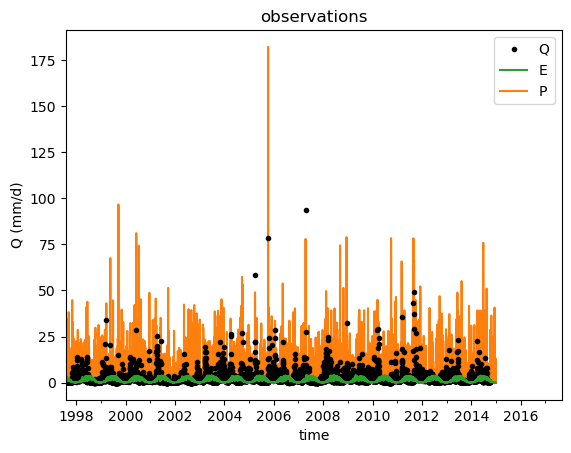

In [37]:
ax = df_Q['Q'].plot(label="Q",marker=".",lw=0,color="k")
ds['evspsblpot'].plot(ax=ax,label="E",color="C2")
ds['pr'].plot(ax=ax,zorder=-2,label="P",color="C1")
ax.set_xlim((pd.Timestamp(experiment_start_date),pd.Timestamp(experiment_end_date)))
ax.set_ylabel("Q (mm/d)")
ax.set_title("observations")
ax.legend();

In [38]:
df_combined = ds_obs.to_pandas()
df_combined['P'] = ds['pr'].to_pandas()
df_combined['EP'] = ds['evspsblpot'].to_pandas()
df_combined = df_combined.dropna(axis=0)

In [44]:
sum = df_combined.sum(axis=0)
sum.P - sum.EP, sum.Q

(15029.929311502794, 13621.882134154699)